# Age-Metallicity Relation

In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic
from auriga.snapshot import Snapshot
from auriga.images import figure_setup
from auriga.paths import Paths
from auriga.parser import parse
from auriga.settings import Settings

In [12]:
figure_setup()

## All Subhalo Stars

In [3]:
def read_data(simulation: str) -> tuple:
    """
    This method returns the circularity, the normalized potential and the
    region tag for the stars in the main object of the simulation.

    Parameters
    ----------
    simulation : str
        The simulation to consider.

    Returns
    -------
    tuple
        The properties.
    """
    s = Snapshot(simulation=simulation,
                 loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_stellar_age()
    s.add_circularity()
    s.add_reference_to_potential()
    s.add_normalized_potential()
    s.tag_particles_by_region(disc_std_circ=1.0,
                              disc_min_circ=0.4,
                              cold_disc_delta_circ=0.25,
                              bulge_max_specific_energy=-0.75)
    s.add_metal_abundance(of="Fe", to="H")

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    return (s.stellar_age[is_real_star & is_main_obj],
        s.metal_abundance["Fe/H"][is_real_star & is_main_obj],
        s.region_tag[is_real_star & is_main_obj])

In [10]:
def plot_age_metal_rel_for_galaxy(simulation: str):
    """
    This method creates a plot of the metallicity (Fe/H metal abundance) as
    a function of the age of each star for the stars in the main object.

    Parameters
    ----------
    simulation : str
        The simulation to plot.
    """

    fig = plt.figure(figsize=(3.0, 3.0))
    gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
    ax = gs.subplots(sharex=True, sharey=True)

    ax.label_outer()
    ax.tick_params(which='both', direction="in")
    ax.set_xlim(0, 14)
    ax.set_ylim(-4, 3)
    ax.set_xticks([2, 4, 6, 8, 10, 12])
    ax.set_yticks([-3, -2, -1, 0, 1, 2])
    ax.set_xlabel("Age [Gyr]")
    ax.set_ylabel("[Fe/H] [dex]")

    age, metal_ab, _ = read_data(simulation=simulation)
    _, _, _, im = ax.hist2d(age,
                            metal_ab,
                            cmap='nipy_spectral',
                            bins=200,
                            range=[ax.get_xlim(), ax.get_ylim()],
                            norm=mcolors.LogNorm(vmin=1E0, vmax=1E3))

    cbar = fig.colorbar(im, ax=ax, orientation='vertical',
                        label=r'$N_\mathrm{stars}$',
                        pad=0)
    cbar.ax.set_yticks([1E0, 1E1, 1E2, 1E3])

    ax.text(x=ax.get_xlim()[0],
            y=ax.get_ylim()[1],
            s=simulation.upper(),
            size=8.0,
            ha='left', va='bottom',
            )

    plt.show()

In [23]:
def plot_age_metal_rel_by_region_for_galaxy(simulation: str):
    """
    This method creates a plot of the metallicity (Fe/H metal abundance) as
    a function of the age of each star for the stars in the main object.

    Parameters
    ----------
    simulation : str
        The simulation to plot.
    """

    fig = plt.figure(figsize=(7.4, 2.0))
    gs = fig.add_gridspec(nrows=1, ncols=4, hspace=0.0, wspace=0.0)
    axs = gs.subplots(sharex=True, sharey=True)

    for ax in axs.flat:
        ax.tick_params(which='both', direction="in")
        ax.set_xlim(0, 14)
        ax.set_ylim(-4, 3)
        ax.set_xticks([2, 4, 6, 8, 10, 12])
        ax.set_yticks([-3, -2, -1, 0, 1, 2])
        ax.set_xlabel("Age [Gyr]")
        ax.set_ylabel("[Fe/H] [dex]")
        ax.label_outer()

    age, metal_ab, region_tag = read_data(simulation=simulation)
    for idx, tag in enumerate(np.unique(region_tag)):
        is_region = (region_tag == tag)
        _, _, _, im = axs[idx].hist2d(
            age[is_region],
            metal_ab[is_region],
            cmap='nipy_spectral',
            bins=200,
            range=[axs[idx].get_xlim(), axs[idx].get_ylim()],
            norm=mcolors.LogNorm(vmin=1E0, vmax=1E3))

        settings = Settings()
        axs[idx].text(x=0.05,
                      y=0.05,
                      s=settings.component_labels[settings.components[idx]],
                      size=8.0, transform=axs[idx].transAxes,
                      ha='left', va='bottom',
                      )

        axs[idx].plot(axs[idx].get_xlim(),
                      [np.nanmedian(metal_ab[is_region]),
                       np.nanmedian(metal_ab[is_region])],
                      lw=.25, color='k')
        axs[idx].plot([np.nanmedian(age[is_region]),
                       np.nanmedian(age[is_region])],
                      axs[idx].get_ylim(),
                      lw=.25, color='k')
        axs[idx].plot(np.nanmedian(age[is_region]),
                      np.nanmedian(metal_ab[is_region]),
                     marker='o', mfc='k', ms=2, mew=0)

    cbar = fig.colorbar(im, ax=axs[-1], orientation='vertical',
                        label=r'$N_\mathrm{stars}$',
                        pad=0)
    cbar.ax.set_yticks([1E0, 1E1, 1E2, 1E3])

    axs[0].text(x=axs[0].get_xlim()[0],
            y=axs[0].get_ylim()[1],
            s=simulation.upper(),
            size=8.0,
            ha='left', va='bottom',
            )

    plt.show()

/u/fiza/conda-envs/auriga/lib/python3.7/site-packages/astropy/cosmology/core.py:1990: RuntimeWarning: invalid value encountered in true_divide
  (1 + z)**3))
/u/fiza/.local/lib/python3.7/site-packages/numpy/lib/scimath.py:136: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


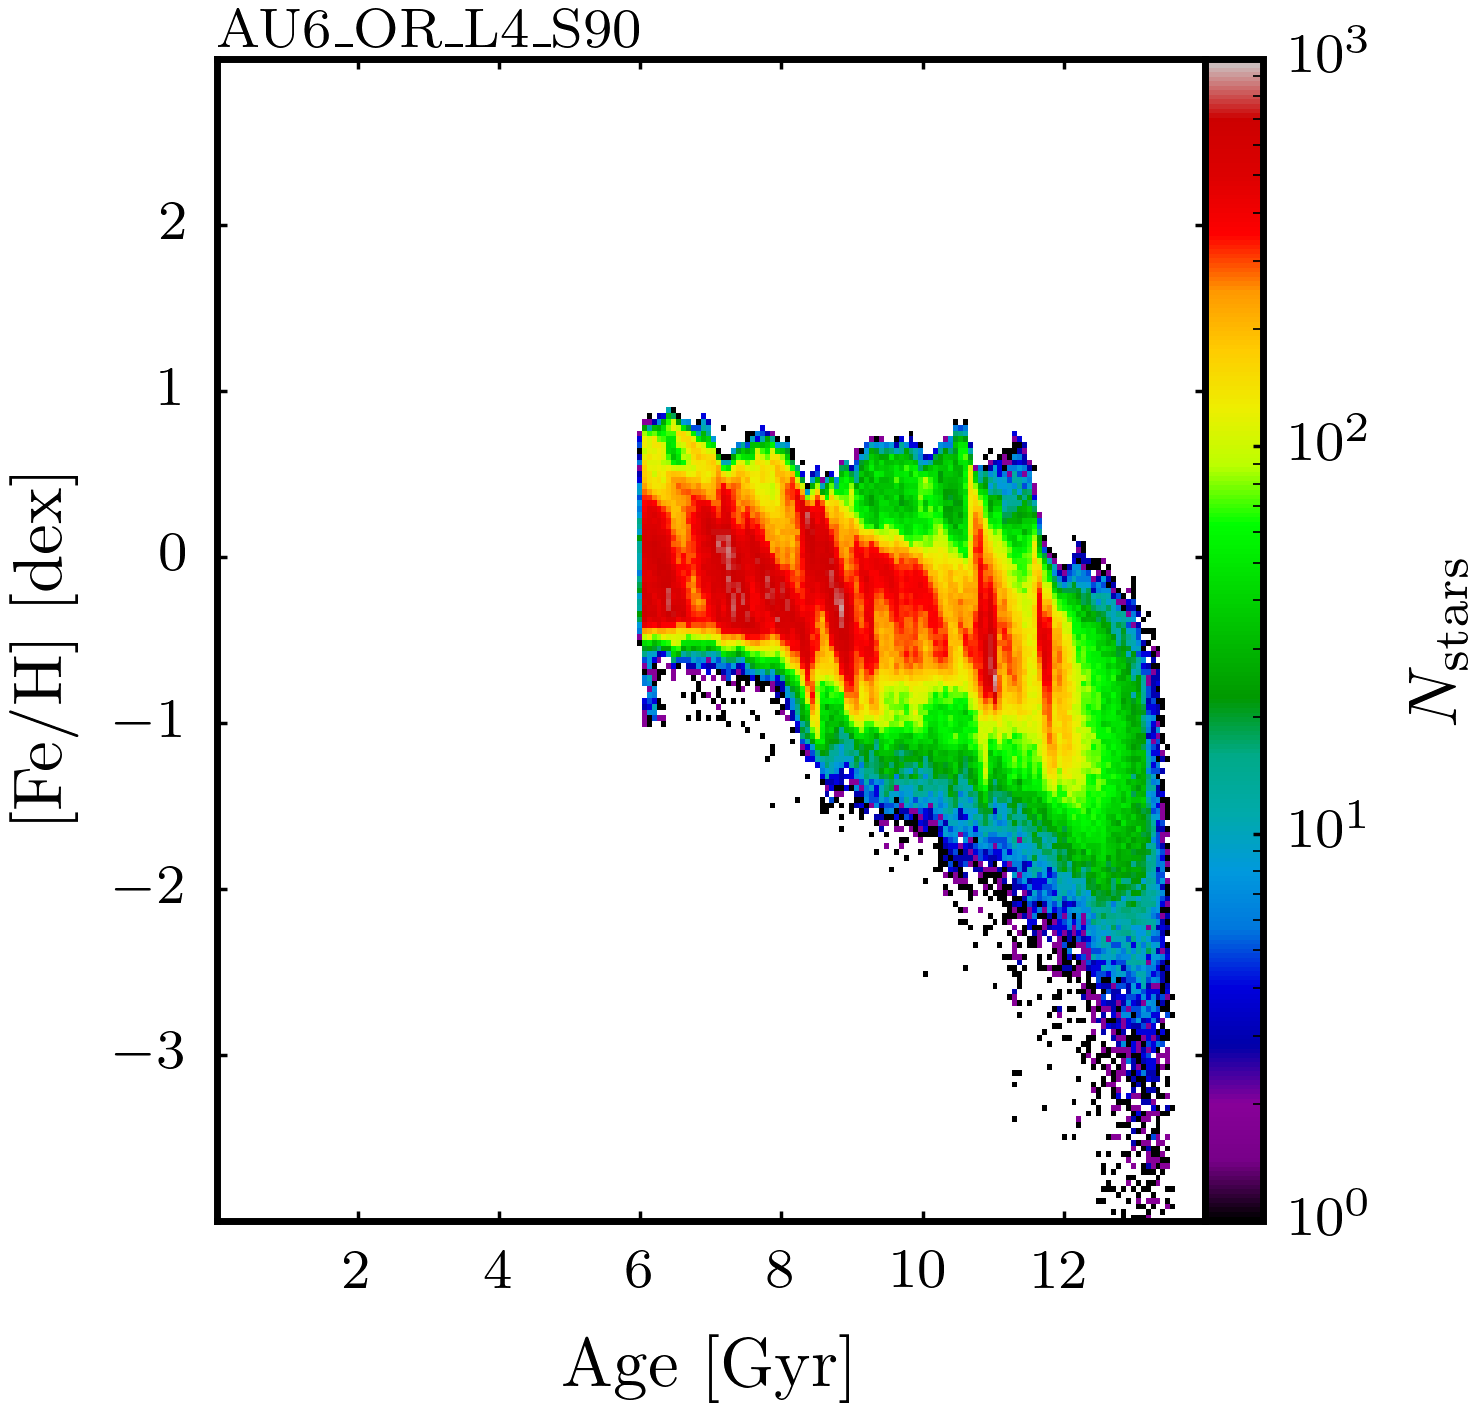

In [14]:
plot_age_metal_rel_for_galaxy(simulation="au6_or_l4_s90")

/u/fiza/conda-envs/auriga/lib/python3.7/site-packages/astropy/cosmology/core.py:1990: RuntimeWarning: invalid value encountered in true_divide
  (1 + z)**3))
/u/fiza/.local/lib/python3.7/site-packages/numpy/lib/scimath.py:136: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


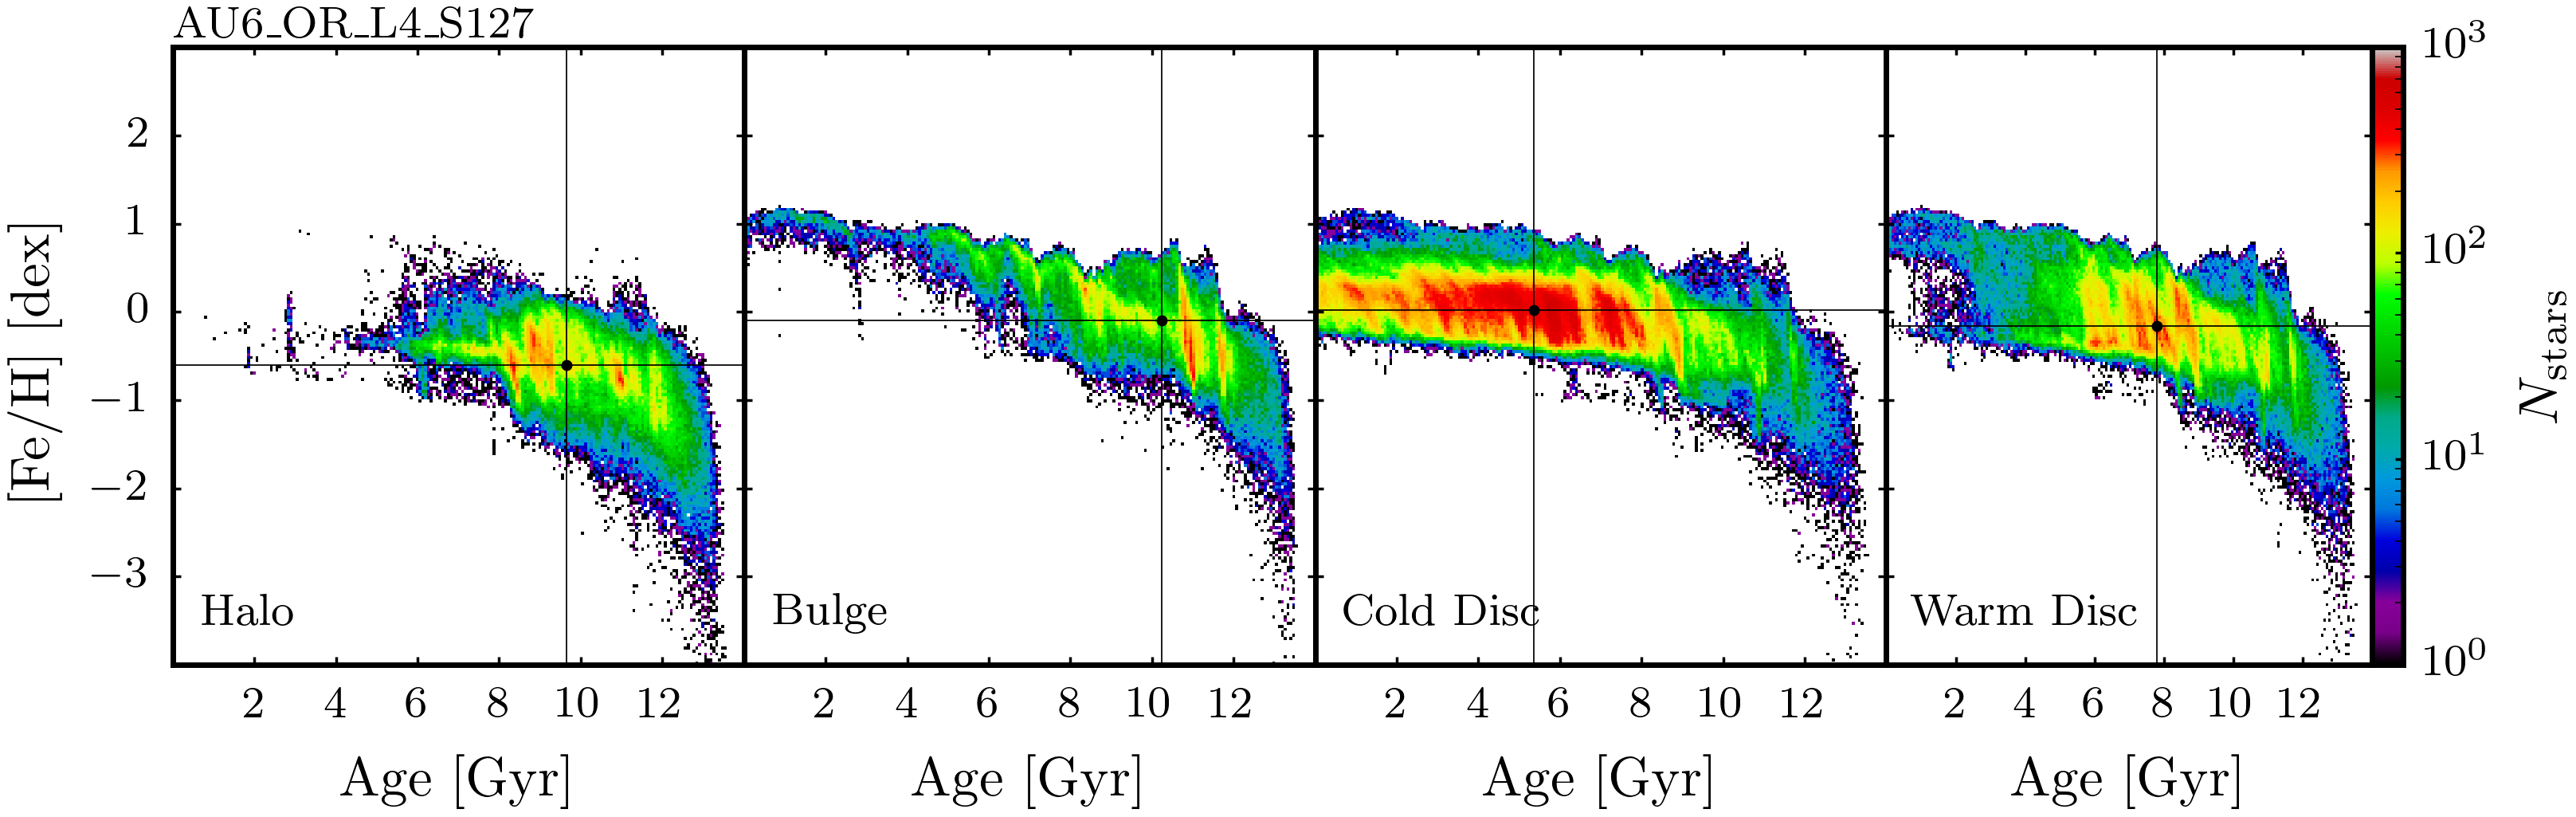

In [24]:
plot_age_metal_rel_by_region_for_galaxy(simulation="au6_or_l4_s127")